# Data Preprocessing: NASA - Nearest Earth Objects
<img src="../assets/nasa.jpg" alt="Title-Pic">

# Imports

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pandas import Series, DataFrame
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (12, 7), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})
warnings.filterwarnings('ignore')

# Data

In [27]:
df_raw_data = pd.read_csv("../data/neo_v2.csv")
df = df_raw_data.copy()
df

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True
...,...,...,...,...,...,...,...,...,...,...
90831,3763337,(2016 VX1),0.026580,0.059435,52078.886692,1.230039e+07,Earth,False,25.00,False
90832,3837603,(2019 AD3),0.016771,0.037501,46114.605073,5.432121e+07,Earth,False,26.00,False
90833,54017201,(2020 JP3),0.031956,0.071456,7566.807732,2.840077e+07,Earth,False,24.60,False
90834,54115824,(2021 CN5),0.007321,0.016370,69199.154484,6.869206e+07,Earth,False,27.80,False


# Data Preprocessing

## First Overview

In [28]:
df.nunique()

id                    27423
name                  27423
est_diameter_min       1638
est_diameter_max       1638
relative_velocity     90828
miss_distance         90536
orbiting_body             1
sentry_object             1
absolute_magnitude     1638
hazardous                 2
dtype: int64

In [29]:
df = df.iloc[df["id"].drop_duplicates().index]
df.shape

(27423, 10)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27423 entries, 0 to 90823
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  27423 non-null  int64  
 1   name                27423 non-null  object 
 2   est_diameter_min    27423 non-null  float64
 3   est_diameter_max    27423 non-null  float64
 4   relative_velocity   27423 non-null  float64
 5   miss_distance       27423 non-null  float64
 6   orbiting_body       27423 non-null  object 
 7   sentry_object       27423 non-null  bool   
 8   absolute_magnitude  27423 non-null  float64
 9   hazardous           27423 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 1.9+ MB


In [31]:
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,2.742300e+04,27423.000000,27423.000000,27423.000000,2.742300e+04,27423.000000
mean,1.522211e+07,0.139082,0.310996,49280.648011,3.313929e+07,23.361668
std,2.137963e+07,0.374420,0.837229,26258.688410,2.356242e+07,2.869921
min,2.000433e+06,0.000609,0.001362,561.695602,9.316925e+03,9.230000
25%,3.520758e+06,0.021113,0.047211,29017.538565,1.023815e+07,21.200000
50%,3.756059e+06,0.050647,0.113250,45144.895226,3.136635e+07,23.600000
75%,3.968766e+06,0.152952,0.342011,64915.211515,5.427982e+07,25.500000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [32]:
df.describe(include=["O"])

,name,orbiting_body
count,27423,27423
unique,27423,1
top,162635 (2000 SS164),Earth
freq,1,27423


## Missing Values

In [33]:
df.isna().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

# Helper Function & Constants

In [34]:
# columns
ID = "id"
NAME = "name"
EST_DIAMETER_MIN = "est_diameter_min"
EST_DIAMETER_MAX = "est_diameter_max"
REL_VELOCITY = "relative_velocity"
MISS_DISTANCE = "miss_distance"
ORBITING_BODY = "orbiting_body"
SENTRY_OBJECT = "sentry_object"
ABS_MAGNITUDE = "absolute_magnitude"
TARGET_HAZARDOUS = "hazardous"

# added columns
TARGET = "Target"

In [35]:
def plot_dist(column_name):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    ax1, ax2 = axes
    
    title = f"Distribution of {column_name}"
    ax1.set_title(title)
    ax2.set_title(title)

    sns.boxplot(x=column_name, data=df, ax=ax1)
    df[column_name].hist(ax=ax2)

    print(f"Skew: \t {df[column_name].skew()}")

In [36]:
def plot_dist_cat(column_name):
    g = sns.countplot(x=column_name, data=df, color="C0")
    g.tick_params(axis='x', rotation=45)
    g.set_title(f"Distribution of {column_name}")

## Drop Features

In [37]:
df.drop(columns=[ID, NAME, ORBITING_BODY, SENTRY_OBJECT, EST_DIAMETER_MAX], inplace=True)
df.head(3)

,est_diameter_min,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,13569.249224,5.483974e+07,16.73,False
1,0.265800,73588.726663,6.143813e+07,20.00,True
2,0.722030,114258.692129,4.979872e+07,17.83,False


## Map Target

In [38]:
df[TARGET_HAZARDOUS] = df[TARGET_HAZARDOUS].map({False: 0, True: 1})
df[TARGET_HAZARDOUS].value_counts()

0    25250
1     2173
Name: hazardous, dtype: int64

## Log-Transformation

In [39]:
# DEVTED with fillna(0) after log10() 
def log_transform(cols):
    return np.log10(cols)

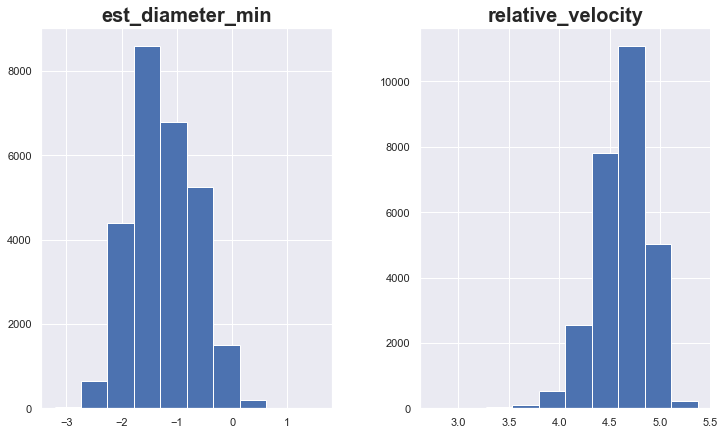

In [40]:
log_cols = [EST_DIAMETER_MIN, REL_VELOCITY]

df[log_cols] = log_transform(df[log_cols])
df[log_cols].hist();

In [41]:
df[log_cols].describe()

,est_diameter_min,relative_velocity
count,27423.000000,27423.000000
mean,-1.247779,4.625399
std,0.573984,0.257482
min,-3.215445,2.749501
25%,-1.675445,4.462661
50%,-1.295445,4.654609
75%,-0.815445,4.812346
max,1.578555,5.374730


In [42]:
df[log_cols].skew()

est_diameter_min     0.204530
relative_velocity   -0.744835
dtype: float64

In [43]:
scale_cols = df.drop(columns=[TARGET_HAZARDOUS]).columns
df[scale_cols] = StandardScaler().fit_transform(df[scale_cols])
df

,est_diameter_min,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2.310792,-1.914127,0.920994,-2.310792,0
1,1.171367,0.937607,1.201038,-1.171367,1
2,1.927499,1.679724,0.707047,-1.927499,0
3,0.404781,-0.899394,-0.326980,-0.404781,0
4,1.140006,0.021020,0.557520,-1.140006,1
...,...,...,...,...,...
90561,0.861248,-3.720634,0.318524,-0.861248,0
90608,1.070317,-0.357178,0.026533,-1.070317,0
90711,1.289839,1.510352,1.248093,-1.289839,0
90806,1.380435,0.738323,1.286294,-1.380435,0


## Over Sampling the data

In [44]:
inputs_df = df.drop(columns=[TARGET_HAZARDOUS])
input_names = inputs_df.columns

inputs = inputs_df.to_numpy()
targets = df[TARGET_HAZARDOUS].to_numpy()
inputs.shape, targets.shape, input_names.shape

((27423, 4), (27423,), (4,))

In [45]:
sm = BorderlineSMOTE(random_state=101)
inputs, targets = sm.fit_resample(inputs, targets)
targets = targets.reshape(-1, 1)

inputs.shape, targets.shape

((50500, 4), (50500, 1))

In [46]:
tmp_df = DataFrame(data=np.hstack([inputs, targets]), columns=np.hstack([input_names, "target"]))
tmp_df.head()

,est_diameter_min,relative_velocity,miss_distance,absolute_magnitude,target
0,2.310792,-1.914127,0.920994,-2.310792,0.0
1,1.171367,0.937607,1.201038,-1.171367,1.0
2,1.927499,1.679724,0.707047,-1.927499,0.0
3,0.404781,-0.899394,-0.326980,-0.404781,0.0
4,1.140006,0.021020,0.557520,-1.140006,1.0


In [47]:
tmp_df["target"].value_counts()

0.0    25250
1.0    25250
Name: target, dtype: int64

# Data Export

In [48]:
np.savez("../model_data/nasa_prep_data", inputs=inputs, targets=targets, input_column_names=input_names)

In [49]:
test_load = np.load("../model_data/nasa_prep_data.npz", allow_pickle=True)
test_load["inputs"].shape, test_load["targets"].shape, test_load["input_column_names"]

((50500, 4),
 (50500, 1),
 array(['est_diameter_min', 'relative_velocity', 'miss_distance',
        'absolute_magnitude'], dtype=object))